# Data Overview

In [6]:
import pandas as pd
import numpy as np 

In [7]:
df = pd.read_excel("amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


# Data Preprocessing

In [15]:
import nltk
from  nltk.corpus import stopwords
from textblob import Word



In [ ]:
df["Review"] = df["Review"].str.lower()  

In [9]:
df["Review"] = df["Review"].str.replace(r"[^\w\s]","",regex=True)

In [10]:
df["Review"] = df["Review"].str.replace(r"\d","",regex=True)

In [13]:
sw = stopwords.words("english")
df["Review"] = df["Review"].apply(lambda x : " ".join(x for x in str(x).split() if x not in sw))

In [14]:
temp_df = pd.Series(" ".join(df["Review"]).split()).value_counts()
drops = temp_df[temp_df < 1000].index

df["Review"] = df["Review"].apply(
    lambda x : " ".join([word for word in x.split() if word not in drops])
)


In [16]:
df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Text Visualization

In [23]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud



In [19]:
tf = pd.Series(" ".join(df["Review"].dropna()).split()).value_counts().reset_index()
tf.columns = ["words", "tf"]
tf.sort_values("tf", ascending=False)


,words,tf
0,curtain,1891
1,love,1312
2,room,1116
3,like,1037


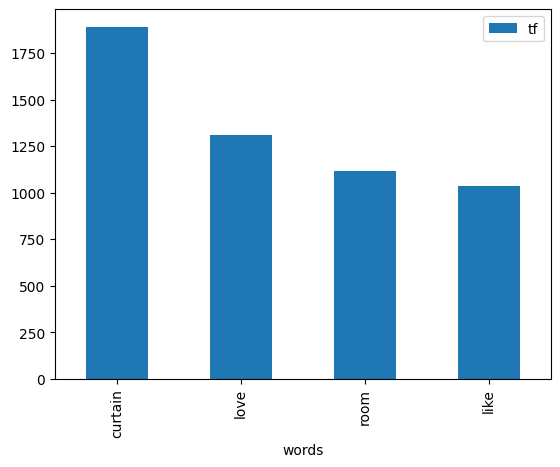

In [21]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

In [22]:
text = " ".join(i for i in df.Review)

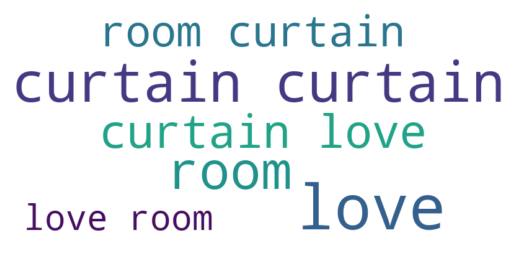

In [26]:
wc = WordCloud(max_font_size=100,width=800,height=400,background_color="white")
wordcloud = wc.generate(text)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Analysis

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [32]:
sia = SentimentIntensityAnalyzer()
df["Review"][0:10].apply(lambda x :sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
3    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
5    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
7    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
8    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: Review, dtype: object

In [34]:
df["Review"][0:10].apply(lambda x :sia.polarity_scores(x)["compound"])

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Review, dtype: float64

In [36]:
df["Review"][0:10].apply(lambda x:"pos" if sia.polarity_scores(x)["compound"]>0 else "neg")

0    neg
1    neg
2    neg
3    neg
4    neg
5    neg
6    neg
7    neg
8    neg
9    neg
Name: Review, dtype: object

In [37]:
df["sentiment_label"] = df["Review"].apply(lambda x : "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [38]:
df.head()

,Star,HelpFul,Title,Review,sentiment_label
0,5,0,looks great,,neg
1,5,0,Pattern did not align between the two panels.,,neg
2,5,0,Imagery is stretched. Still fun.,,neg
3,5,0,Que se ven elegantes muy finas,,neg
4,5,0,Wow great purchase,,neg


# Preparation for Modeling

In [43]:
from sklearn.preprocessing import LabelEncoder

df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

y = df["sentiment_label"]
X = df["Review"]


tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)


# modeling

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

log_model = LogisticRegression()
log_model.fit(X_tf_idf_word, y) 
cross_val_score(
    log_model,
    X_tf_idf_word,
    y,
    scoring = "accuracy",
    cv= 5
).mean()



0.9962579543272015

In [60]:

sample_text = df["Review"].sample(1, random_state=42).values[0]
X_sample = tf_idf_word_vectorizer.transform([sample_text])
prediction = log_model.predict(X_sample)

print("Örneklem:", sample_text)
print("Tahmin sonucu:", prediction[0])


Örneklem: love curtain like
Tahmin sonucu: 1
